In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

OUTDATED_IGNORE=1

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# clean text
import re
import contractions
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# progress bars
from tqdm.notebook import tqdm, trange
import time

# common ngrams
from nltk.util import ngrams
from nltk import FreqDist
from wordcloud import WordCloud
from PIL import Image

# sentiment analysis
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# word network
import networkx as nx
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, LabelSet
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Purples8
from bokeh.transform import linear_cmap
from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges

# topic modeling
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# t-test
import pingouin

In [8]:
def clean_text(text):
    # remove any @ mentions and extra white spaces
    remove_mentions = " ".join(filter(lambda x: x[0]!='@', text.split())).strip()
    
    # remove URLs
    remove_URLs = " ".join([x for x in remove_mentions.split() if 'http' not in x])
    
    # remove special characters/numbers and convert to lowercase
    remove_spec_char = re.sub("[^a-zA-Z ]", '', remove_URLs).lower()
    
    # fix characters that repeat 3+ times
    remove_rep = re.sub(r'(.)\1+', r'\1\1', remove_spec_char) 

    # expand contractions
    expanded_text = " ".join([contractions.fix(x) for x in remove_rep.split()]) 
    
    # remove stop words
    filtered_text = " ".join([word for word in expanded_text.split() if not word in stop_words])
    
    return filtered_text

# Import and Clean Data

In [9]:
# import Opiates data
df1 = pd.read_csv('SubredditDatasets/opiates.csv')
opiates = df1[(df1['body'].notnull()) & (df1['created']<=1622519999)].drop_duplicates().reset_index(drop=True).copy()
opiates['date'] = pd.to_datetime(opiates['created'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d')))
opiates = opiates.drop(columns=['title', 'created', 'id', 'url'])

# clean dataset
opiates['cleaned_text'] = opiates['body'].apply(clean_text)

# add tokens column
opiates['tokens'] = [post.split() for post in opiates['cleaned_text']]
opiates['post_length'] = opiates['tokens'].apply(lambda x: len(x))

# add month column
opiates['month'] = opiates['date'].dt.to_period('M')

In [10]:
# import Opiates Recovery data
df2 = pd.read_csv('SubredditDatasets/recovery.csv')
recovery = df2[(df2['body'].notnull()) & (df2['created']<=1622519999)].drop_duplicates().reset_index(drop=True).copy()
recovery['date'] = pd.to_datetime(recovery['created'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d')))
recovery = recovery.drop(columns=['title','created', 'id', 'url'])

# clean dataset
recovery['cleaned_text'] = recovery['body'].apply(clean_text)

# add tokens column
recovery['tokens'] = [post.split() for post in recovery['cleaned_text']]
recovery['post_length'] = recovery['tokens'].apply(lambda x: len(x))

# add month column
recovery['month'] = recovery['date'].dt.to_period('M')

# Dataset Summary

## Opiates

In [11]:
print('There is a total of', opiates.shape[0], 'posts.')

average = sum(opiates['post_length'])/len(opiates['post_length'])
print('There is an average of', int(average), 'words per cleaned post.')

print('There are', len(opiates['name'].unique()), 'unique users.')

num_posts_per_user = opiates.groupby('name').size()
print("Minimum Number of Posts Per User:", min(num_posts_per_user))
print("Average Number of Posts Per User:", int(sum(num_posts_per_user)/len(num_posts_per_user)))
print("Maximum Number of Posts Per User:", max(num_posts_per_user))

There is a total of 31815 posts.
There is an average of 61 words per cleaned post.
There are 13045 unique users.
Minimum Number of Posts Per User: 1
Average Number of Posts Per User: 2
Maximum Number of Posts Per User: 193


## Opiates Recovery

In [12]:
print('There is a total of', recovery.shape[0], 'posts.')

average = sum(recovery['post_length'])/len(recovery['post_length'])
print('There is an average of', int(average), 'words per cleaned post.')

print('There are', len(recovery['name'].unique()), 'unique users.')

num_posts_per_user = recovery.groupby('name').size()
print("Minimum Number of Posts Per User:", min(num_posts_per_user))
print("Average Number of Posts Per User:", int(sum(num_posts_per_user)/len(num_posts_per_user)))
print("Maximum Number of Posts Per User:", max(num_posts_per_user))

There is a total of 10266 posts.
There is an average of 87 words per cleaned post.
There are 4596 unique users.
Minimum Number of Posts Per User: 1
Average Number of Posts Per User: 2
Maximum Number of Posts Per User: 314


# Common Words

In [13]:
def color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = 0 # 0 - 360
    s = 0 # 0 - 100
    l = random_state.randint(30, 70) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

## Opiates

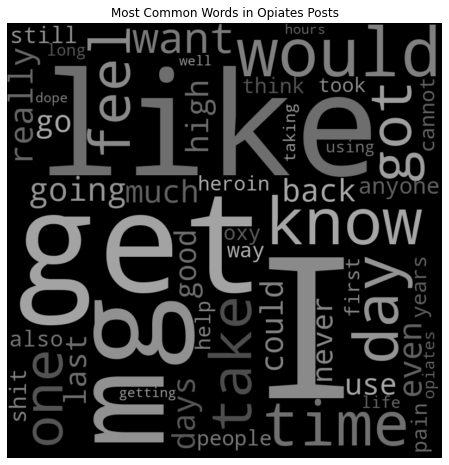

In [14]:
all_words = " ".join(opiates['cleaned_text'])
tokens = all_words.split()
freq = FreqDist(list(tokens)).most_common(50)
opiates_common_words = pd.DataFrame(freq, columns=['words', 'freq'])

wordcloud = WordCloud(width=800, 
                      height=800, 
                      background_color='black', 
                      color_func=color_func).generate_from_frequencies(dict(freq))

plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Opiates Posts')
plt.axis('off')
plt.show()

## Opiates Recovery

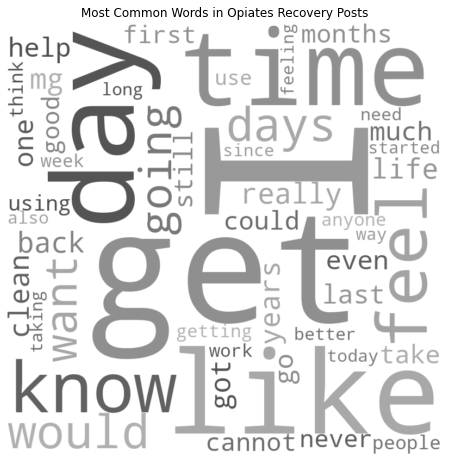

In [15]:
all_words = " ".join(recovery['cleaned_text'])
tokens = all_words.split()
freq = FreqDist(list(tokens)).most_common(50)
recovery_common_words = pd.DataFrame(freq, columns=['words', 'freq'])

wordcloud = WordCloud(width=800, 
                      height=800, 
                      background_color='white', 
                      color_func=color_func).generate_from_frequencies(dict(freq))

plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Opiates Recovery Posts')
plt.axis('off')
plt.show()

In [16]:
# words that appear in opiates top 50, but not recovery top 50
opiates_list = list(opiates_common_words['words'])
recovery_list = list(recovery_common_words['words'])
print('words in opiates and not in recovery:', np.setdiff1d(opiates_list, recovery_list))
print('words in recovery and not in opiates:', np.setdiff1d(recovery_list, opiates_list))

words in opiates and not in recovery: ['dope' 'heroin' 'high' 'hours' 'opiates' 'oxy' 'pain' 'shit' 'took'
 'well']
words in recovery and not in opiates: ['better' 'clean' 'feeling' 'months' 'need' 'since' 'started' 'today'
 'week' 'work']


# Building Sentiment Analysis Model

reddit dataset: https://www.kaggle.com/cosmos98/twitter-and-reddit-sentimental-analysis-dataset

In [17]:
# import training dataset
reddit = pd.read_csv('TrainingDatasets/Labeled_Reddit_Data.csv')
reddit = reddit.dropna().reset_index(drop=True)
reddit.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [18]:
reddit.category.value_counts()

 1    15830
 0    13042
-1     8277
Name: category, dtype: int64

              precision    recall  f1-score   support

          -1       0.89      0.76      0.82      1644
           0       0.90      0.97      0.93      2639
           1       0.90      0.91      0.91      3147

    accuracy                           0.90      7430
   macro avg       0.90      0.88      0.89      7430
weighted avg       0.90      0.90      0.90      7430



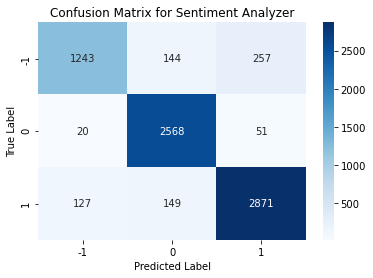

In [19]:
# build sentiment analyzer
X = reddit['clean_comment']
y = reddit['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

train = []
test = []

for i in X_train.index:
    train.append(X_train[i])

for i in X_test.index:
    test.append(X_test[i])

tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit_transform(train)
tfidf_test = tfidf.transform(test)

svc = LinearSVC(random_state=2021, max_iter=15000)
svc.fit(tfidf_train, y_train)

y_pred = svc.predict(tfidf_test)

print(classification_report(y_test, y_pred))

ax = sns.heatmap(confusion_matrix(y_test, y_pred), 
            cmap='Blues', 
            annot=True, 
            fmt='g', 
            xticklabels=[-1,0,1], 
            yticklabels=[-1,0,1])
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.title("Confusion Matrix for Sentiment Analyzer")
plt.show()

In [20]:
# test model on a dataset that is unseen during training phase
twitter = pd.read_csv('TrainingDatasets/Labeled_Twitter_Data.csv')
twitter = twitter.dropna().reset_index(drop=True)
twitter.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [21]:
twitter.category.value_counts()

 1.0    72249
 0.0    55211
-1.0    35509
Name: category, dtype: int64

              precision    recall  f1-score   support

        -1.0       0.87      0.70      0.78     35509
         0.0       0.80      0.96      0.87     55211
         1.0       0.91      0.86      0.89     72249

    accuracy                           0.86    162969
   macro avg       0.86      0.84      0.85    162969
weighted avg       0.87      0.86      0.86    162969



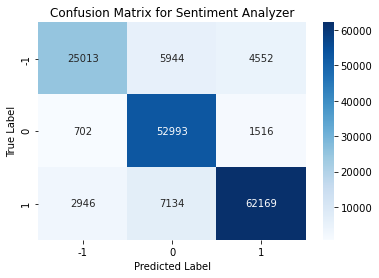

In [22]:
corpus_twitter = []
for i in twitter.index:
    corpus_twitter.append(twitter['clean_text'][i])

X_twitter = tfidf.transform(corpus_twitter)
y_twitter = svc.predict(X_twitter)

print(classification_report(twitter['category'], y_twitter))

ax = sns.heatmap(confusion_matrix(twitter['category'], y_twitter), 
            cmap='Blues', 
            annot=True, 
            fmt='g', 
            xticklabels=[-1,0,1], 
            yticklabels=[-1,0,1])
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.title("Confusion Matrix for Sentiment Analyzer")
plt.show()

# Sentiment Analysis

In [23]:
# use model to label opiates posts
corpus_opiates = []
for i in range(len(opiates['cleaned_text'])):
    corpus_opiates.append(opiates['cleaned_text'][i])
    
X_opiates = tfidf.transform(corpus_opiates)
y_opiates = svc.predict(X_opiates)

opiates['label'] = y_opiates

In [24]:
opiates.label.value_counts()

 1    19214
-1     9212
 0     3389
Name: label, dtype: int64

In [25]:
# use models to label recovery posts
corpus_recovery = []
for i in range(len(recovery['cleaned_text'])):
    corpus_recovery.append(recovery['cleaned_text'][i])

X_recovery = tfidf.transform(corpus_recovery)
y_recovery = svc.predict(X_recovery)

recovery['label'] = y_recovery

In [26]:
recovery.label.value_counts()

 1    6746
-1    2762
 0     758
Name: label, dtype: int64

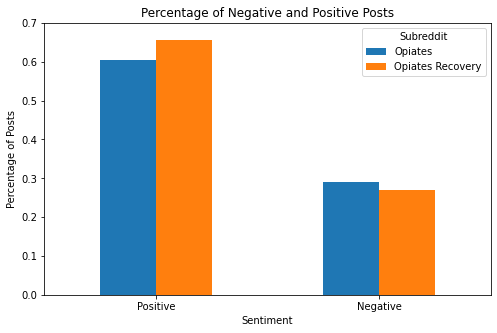

In [27]:
# calculate the percent of posts that are positive/negative for each subreddit
compare = pd.DataFrame()
compare['Sentiment'] = ['Positive', 'Negative']
compare['Opiates'] = [len(opiates[opiates['label']==1])/len(opiates['label']), 
                      len(opiates[opiates['label']==-1])/len(opiates['label'])]
compare['Opiates Recovery'] = [len(recovery[recovery['label']==1])/len(recovery['label']),
                               len(recovery[recovery['label']==-1])/len(recovery['label'])]
compare = compare.set_index('Sentiment')

compare.plot(kind='bar', figsize=(8,5)).legend(title='Subreddit')
plt.xticks(rotation=0)
plt.ylabel('Percentage of Posts')
plt.yticks(np.arange(0, 0.8, step=0.1))
plt.title('Percentage of Negative and Positive Posts')
plt.show()

In [28]:
# calculate percent of posts per month that are positive/negative
def calc_sentiment_percentage(df):
    tmp = df[['label', 'date']].copy()
    sentiment_df = pd.DataFrame()

    sentiment_df['date'] = pd.DataFrame(tmp.groupby(tmp['date'].dt.to_period('M')).size()).reset_index()['date']
    sentiment_df['# of Posts'] = pd.DataFrame(tmp.groupby(tmp['date'].dt.to_period('M')).size()).reset_index()[0]
    sentiment_df['# of Neg Posts'] = pd.DataFrame(tmp[tmp['label']==-1].groupby(tmp['date'].dt.to_period('M')).size()).reset_index()[0]
    sentiment_df['% of Neg Posts'] = round(sentiment_df['# of Neg Posts']/sentiment_df['# of Posts'], 2)
    sentiment_df['# of Pos Posts'] = pd.DataFrame(tmp[tmp['label']==1].groupby(tmp['date'].dt.to_period('M')).size()).reset_index()[0]
    sentiment_df['% of Pos Posts'] = round(sentiment_df['# of Pos Posts']/sentiment_df['# of Posts'], 2)
    
    return sentiment_df.set_index('date')

In [29]:
opiates_sentiment_perc = calc_sentiment_percentage(opiates)
recovery_sentiment_perc = calc_sentiment_percentage(recovery)

In [30]:
opiates_sentiment_perc.head()

,# of Posts,# of Neg Posts,% of Neg Posts,# of Pos Posts,% of Pos Posts
date,,,,,
2019-01,1553,424,0.27,959,0.62
2019-02,1466,383,0.26,928,0.63
2019-03,1358,416,0.31,788,0.58
2019-04,1148,340,0.30,697,0.61
2019-05,1337,377,0.28,813,0.61


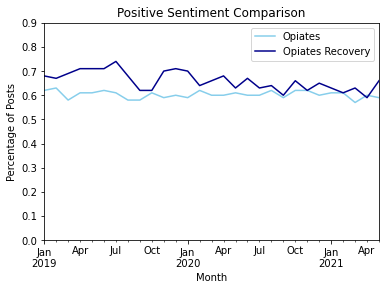

In [31]:
opiates_sentiment_perc['% of Pos Posts'].plot(label="Opiates", color="skyblue", linestyle="-")
recovery_sentiment_perc['% of Pos Posts'].plot(label="Opiates Recovery", color="darkblue", linestyle="-")
plt.xlabel("Month")
plt.ylabel("Percentage of Posts")
plt.yticks(np.arange(0, 1, step=0.1))
plt.title("Positive Sentiment Comparison")
plt.legend()
plt.show()

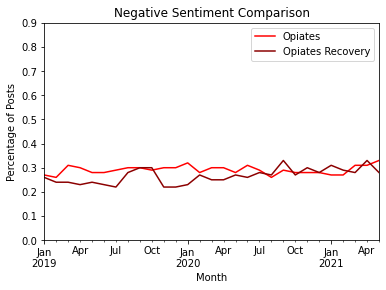

In [32]:
opiates_sentiment_perc['% of Neg Posts'].plot(label="Opiates", color="red", linestyle="-")
recovery_sentiment_perc['% of Neg Posts'].plot(label="Opiates Recovery", color="darkred", linestyle="-")
plt.xlabel("Month")
plt.ylabel("Percentage of Posts")
plt.yticks(np.arange(0, 1, step=0.1))
plt.title("Negative Sentiment Comparison")
plt.legend()
plt.show()

In [33]:
print('T-test for positive sentiment:')
pingouin.ttest(opiates_sentiment_perc['% of Pos Posts'], recovery_sentiment_perc['% of Pos Posts'])

T-test for positive sentiment:


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-7.367981,56,two-sided,8.530435e-10,"[-0.07, -0.04]",1.934927,9.03e+06,1.0


In [34]:
print('T-test for negative sentiment:')
pingouin.ttest(opiates_sentiment_perc['% of Neg Posts'], recovery_sentiment_perc['% of Neg Posts'])

T-test for negative sentiment:


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.650467,56,two-sided,0.000577,"[0.01, 0.04]",0.958659,49.275,0.948154


# Word Networks

In [35]:
parts_of_speech = {'adjectives': ['JJ', 'JJR', 'JJS'], 
                   'nouns': ['NN', 'NNS'], 
                   'verbs': ['VB', 'VBG', 'VBD', 'VBN', 'VBP', 'VBZ']}

In [36]:
# create opiates parts of speech columns
for key, values in parts_of_speech.items():
    pos_list = []
    for i in trange(len(opiates['cleaned_text'])):
        words = nltk.word_tokenize(opiates['cleaned_text'][i])
        pos = [k for k,v in nltk.pos_tag(words) if v in values]
        pos_list.append(" ".join(pos))
    opiates[key] = pos_list

  0%|          | 0/31815 [00:00<?, ?it/s]

  0%|          | 0/31815 [00:00<?, ?it/s]

  0%|          | 0/31815 [00:00<?, ?it/s]

In [37]:
# create recovery parts of speech columns 
for key, values in parts_of_speech.items():
    pos_list = []
    for i in trange(len(recovery['cleaned_text'])):
        words = nltk.word_tokenize(recovery['cleaned_text'][i])
        pos = [k for k,v in nltk.pos_tag(words) if v in values]
        pos_list.append(" ".join(pos))
    recovery[key] = pos_list

  0%|          | 0/10266 [00:00<?, ?it/s]

  0%|          | 0/10266 [00:00<?, ?it/s]

  0%|          | 0/10266 [00:00<?, ?it/s]

In [36]:
def correlations(df, column):
    # create list of all tokens
    all_words = " ".join(df[column])
    all_words = pd.DataFrame(all_words.split(), columns=['tokens'])
    
    # identify unique tokens and sort by number of appearances
    all_words = all_words.groupby('tokens').size().reset_index(name='counts').sort_values('counts', ascending=False)
    all_words = all_words.reset_index(drop=True)
    
    top_tokens = list(all_words[:250]['tokens'])
    
    # create matrix that holds how many times popular tokens appear in each post
    word_count_per_post = pd.DataFrame()
    for token in top_tokens:
        token_word_count = []
        for i in range(len(df['tokens'])):
            count = 0
            for word in df['tokens'][i]:
                if token == word:
                    count += 1
            token_word_count.append(count)
        word_count_per_post[token] = token_word_count
    
    # calculate correlation coefficients for word pairs
    pearson = word_count_per_post.corr(method='pearson')
    spearman = word_count_per_post.corr(method='spearman')
    
    return pearson, spearman

In [70]:
opiates_adj_pearson, opiates_adj_spearman = correlations(opiates, 'adjectives')
opiates_nouns_pearson, opiates_nouns_spearman = correlations(opiates, 'nouns')
opiates_verbs_pearson, opiates_verbs_spearman = correlations(opiates, 'verbs')

In [71]:
recovery_adj_pearson, recovery_adj_spearman = correlations(recovery, 'adjectives')
recovery_nouns_pearson, recovery_nouns_spearman = correlations(recovery, 'nouns')
recovery_verbs_pearson, recovery_verbs_spearman = correlations(recovery, 'verbs')

In [39]:
def build_G(correlation, word='empty', threshold=0.1):
    links = correlation.stack().reset_index()
    filtered_links = links.loc[(links['level_0'] != links['level_1'])]
    filtered_links = filtered_links.loc[filtered_links[0]>threshold]
    filtered_links.columns = ['level_0', 'level_1', 'value']

    if word == 'empty':
        G = nx.from_pandas_edgelist(filtered_links, 'level_0', 'level_1', 'value')
    else:
        G=nx.from_pandas_edgelist(filtered_links[filtered_links['level_1']==word], 'level_0', 'level_1', 'value')
    
    return G

In [75]:
def word_networks(G, title):
    # calculate degree of each node
    degrees = dict([(node, degree) for node, degree in nx.degree(G)])
    nx.set_node_attributes(G, name='degree', values=degrees)
    
    color_palette = Purples8
    
    plot = figure(tooltips = [('Word', '@index')], 
                  tools = 'pan,wheel_zoom,save', 
                  active_scroll = 'wheel_zoom', 
                  title=title, 
                  frame_height=800, 
                  frame_width=1200)
    
    network_graph = from_networkx(G, nx.spring_layout)
    
    # set node size, color, and highlight
    min_color = min(network_graph.node_renderer.data_source.data['degree'])
    max_color = max(network_graph.node_renderer.data_source.data['degree'])
    network_graph.node_renderer.glyph = Circle(size='degree', fill_color=linear_cmap('degree',color_palette,min_color,max_color))
    network_graph.node_renderer.hover_glyph = Circle(size='degree', fill_color='white', line_width=2)
    network_graph.node_renderer.selection_glyph = Circle(size='degree', fill_color='white', line_width=2)
    
    # set edge opacity, width, and highlight
    network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
    network_graph.edge_renderer.selection_glyph = MultiLine(line_color='black', line_width=2)
    network_graph.edge_renderer.hover_glyph = MultiLine(line_color='black', line_width=2)
    
    network_graph.selection_policy = NodesAndLinkedEdges()
    network_graph.inspection_policy = NodesAndLinkedEdges()
    
    # add network graph to the plot
    plot.renderers.append(network_graph)
    
    # add labels
    x, y = zip(*network_graph.layout_provider.graph_layout.values())
    node_labels = list(G.nodes())
    source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
    labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', 
                      text_font_size='20px', background_fill_alpha=.7)
    plot.renderers.append(labels)
    
    show(plot)
    filename = title+".html"
    save(plot, filename=filename)
    
    return

In [79]:
G = build_G(recovery_nouns_pearson, threshold=0.2)
word_networks(G, 'RecoveryNounsPearson')

G = build_G(recovery_nouns_spearman, threshold=0.2)
word_networks(G, 'RecoveryNounsSpearman')

G = build_G(recovery_adj_pearson, threshold=0.2)
word_networks(G, 'RecoveryAdjPearson')

G = build_G(recovery_adj_spearman, threshold=0.2)
word_networks(G, 'RecoveryAdjSpearman')

G = build_G(recovery_verbs_pearson, threshold=0.2)
word_networks(G, 'RecoveryVerbsPearson')

G = build_G(recovery_verbs_spearman, threshold=0.2)
word_networks(G, 'RecoveryVerbsSpearman')

# Topic Modeling

## Opiates

In [13]:
tf_vectorizer = CountVectorizer()
token_matrix = tf_vectorizer.fit_transform(list(opiates['cleaned_text']))

# choose number of topics
number_of_topics = 5
lda = LatentDirichletAllocation(n_components=number_of_topics, random_state=1)
lda.fit(token_matrix)

p1 = pyLDAvis.sklearn.prepare(lda, token_matrix, tf_vectorizer)
#pyLDAvis.save_html(p1, 'opiates_topic_modeling.html')

p1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.013228 -0.043972       1        1  35.403321
1      0.118676  0.069311       2        1  29.322564
0      0.104710 -0.055208       3        1  16.034330
2     -0.110228  0.118341       4        1   9.793469
3     -0.126386 -0.088472       5        1   9.446317, topic_info=         Term          Freq         Total Category  logprob  loglift
23457      mg  16801.000000  16801.000000  Default  30.0000  30.0000
37816    take  23097.000000  23097.000000  Default  29.0000  29.0000
11022    drug   6434.000000   6434.000000  Default  28.0000  28.0000
38275    test   2672.000000   2672.000000  Default  27.0000  27.0000
28332  people   6258.000000   6258.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
21470    life    507.940608   5587.138572   Topic5  -5.8661  -0.0383
15395    give    504.239408   5737.828431   Topic5  -5.8734  -0.0722
13801    find    479.268433   5835.709607   Topic5  -5.9242  -0.1399
12457    even    497.926645   8300.201151   Topic5  -5.8860  -0.4540
38589   thing    457.907418   5586.485040   Topic5  -5.9698  -0.1419

[483 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
58         3  0.953366        abg
558        5  0.979595       adin
627        1  0.979075  adventure
1052       3  0.953366        alg
1254       1  0.199652       also
...      ...       ...        ...
43648      2  0.325039       year
43648      3  0.016617       year
43648      4  0.060741       year
43648      5  0.027059       year
43979      2  0.986713    zubsolv

[1203 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 4])

## Opiates Recovery

In [14]:
tf_vectorizer = CountVectorizer()
token_matrix = tf_vectorizer.fit_transform(list(recovery['cleaned_text']))

# choose number of topics
number_of_topics = 5
lda = LatentDirichletAllocation(n_components=number_of_topics, random_state=1)
lda.fit(token_matrix)

p2 = pyLDAvis.sklearn.prepare(lda, token_matrix, tf_vectorizer)
#pyLDAvis.save_html(p2, 'recovery_topic_modeling.html')

p2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.098528 -0.016460       1        1  32.905383
2     -0.065722 -0.048512       2        1  27.378944
1      0.045115 -0.108103       3        1  23.243289
4     -0.069099  0.126341       4        1  10.593353
0      0.188233  0.046735       5        1   5.879031, topic_info=             Term          Freq         Total Category  logprob  loglift
12656          mg   4614.000000   4614.000000  Default  30.0000  30.0000
20169        take   8719.000000   8719.000000  Default  29.0000  29.0000
4672          day  13776.000000  13776.000000  Default  28.0000  28.0000
22991  withdrawal   3471.000000   3471.000000  Default  27.0000  27.0000
5813         dose   1970.000000   1970.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
4581        daily    189.343699    921.406082   Topic5  -5.5914   1.2514
23335        year    275.319873   6592.686264   Topic5  -5.2170  -0.3420
11803        long    218.462632   3303.105832   Topic5  -5.4483   0.1178
8233          get    238.944355  16266.716206   Topic5  -5.3587  -1.3869
5967         drug    198.288083   2535.042850   Topic5  -5.5452   0.2855

[478 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
0          1  0.249077       aa
0          4  0.747230       aa
152        1  0.961373   accuse
167        3  0.939023    achey
204        1  0.040811   acting
...      ...       ...      ...
23374      4  0.014434     yell
23496      3  0.947864   zofran
23519      3  0.059147  zubsolv
23519      4  0.118295  zubsolv
23519      5  0.798489  zubsolv

[1152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 5, 1])